In [1]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 4.6 MB/s 
     |████████████████████████████████| 12.8 MB 59.0 MB/s 
     |████████████████████████████████| 240 kB 82.9 MB/s 
     |████████████████████████████████| 106 kB 82.4 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 929 kB 79.9 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 4.0 MB 51.7 MB/s 
     |████████████████████████████████| 1.9 MB 70.3 MB/s 
     |████████████████████████████████| 112 kB 83.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=15f150020fd2c9437aa9368df0801dd9708e49b54646d020ada27e0e9ee0c12b
  Stored in directory: /root/.cache/pip/wheels/40/2c/d7/aa04

In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

df = pd.read_csv("/content/mnist_train_small.csv")
df = df.loc[df.iloc[:, 0] == 0]

In [3]:
#make (28x28) -> (8x8)

def reduce(arr):
  temp =  np.array(arr).reshape(28, 28).tolist()
  del temp[0]
  del temp[0]
  del temp[-1]
  del temp[-1]
  for i in range(len(temp)):
    del temp[i][0]
    del temp[i][0]
    del temp[i][-1]
    del temp[i][-1]

  temp2 = []
  for i in range(int(len(temp)/3)):
    t = []
    for j in range(int(len(temp)/3)):  
      tt = (temp[3*i][3*j] + temp[3*i+1][3*j] + temp[3*i+2][3*j] 
            + temp[3*i][3*j+1] + temp[3*i+1][3*j+1] + temp[3*i+2][3*j+1]
            + temp[3*i][3*j+2] + temp[3*i+1][3*j+2] + temp[3*i+2][3*j+2])/9
      t.append(int(tt))
    temp2.append(t)

  return temp2


dfToList = df.values
col_name2=["label","pixel0","pixel1",'pixel2','pixel3','pixel4','pixel5','pixel6','pixel7','pixel8','pixel9','pixel10','pixel11','pixel12','pixel13','pixel14','pixel15','pixel16','pixel17','pixel18','pixel19','pixel20','pixel21','pixel22','pixel23','pixel24','pixel25','pixel26','pixel27','pixel28','pixel29','pixel30','pixel31','pixel32','pixel33','pixel34','pixel35','pixel36','pixel37','pixel38','pixel39','pixel40','pixel41','pixel42','pixel43','pixel44','pixel45','pixel46','pixel47','pixel48','pixel49','pixel50','pixel51','pixel52','pixel53','pixel54','pixel55','pixel56','pixel57','pixel58','pixel59','pixel60','pixel61','pixel62','pixel63']

save = []
for digit in dfToList:
  t = [digit[0]]
  t += np.array(reduce(digit[1:])).reshape(64).tolist()
  save.append(t)

save=pd.DataFrame(save, columns=col_name2)

save.to_csv("./mnist_zero_minisize_full.csv", index=False)

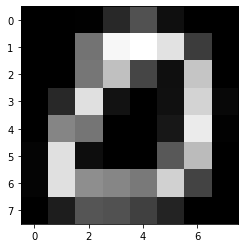

In [4]:
df2 = pd.read_csv("./mnist_zero_minisize_full.csv")

plt.imshow(np.array(df2.iloc[0, 1:]).reshape(8, 8), cmap='gray', interpolation='none')

image = df2.iloc[0, 1:] / 256

image = np.array(image)
image = image.astype(np.float32).reshape(8, 8)


In [5]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            label (int): labels for each feater data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        #df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, 1:] / 256
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="./mnist_zero_minisize_full.csv", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

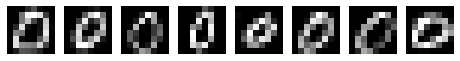

In [6]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [7]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Quantum simulator

n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit import QuantumCircuit, ParameterVector
from torch.autograd import Function

class SubGQuantumCircuit:  
    def __init__(self, n_qubits, n_a_qubits, backend, shots, q_depth ):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_a_qubits = n_a_qubits
        self.n_qubits = n_qubits
        self.noise = ParameterVector('N', n_qubits)
        self.params = ParameterVector("P", n_qubits*q_depth)

        all_qubits = [i for i in range(n_qubits)]

        # Initialise latent vectors
        for i in range(n_qubits):
            self._circuit.ry(self.noise[i], i)

        # Repeated layer
        for i in range(q_depth):
            # Parameterised layer
            for y in range(n_qubits):
                self._circuit.ry(self.params[i*n_qubits+y], y)

            # Control Z gates
            for y in range(n_qubits - 1):
                self._circuit.cz(y, y + 1)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, noise, weights):

        circuit = self._circuit.bind_parameters({self.noise: noise})
        circuit = circuit.bind_parameters({self.params: weights.tolist()})

        qobj = assemble(circuit,
                        shots=self.shots)
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))

        temp = {}
        for key, value in result.items():
          temp[int(key, 2)] = value

        final = []

        for i in range(2**n_qubits):
          if i in temp:
            final.append(temp[i])
          else:
            final.append(0)
        
        final /= np.sum(counts)



        probsgiven0 = final[: (2 ** (n_qubits - n_a_qubits))]

        # Post-Processing
        if np.max(probsgiven0) != 0: probsgiven = probsgiven0 / np.max(probsgiven0)
        else: probsgiven = probsgiven0
        return np.array(probsgiven)

     
class QFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift, weights):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input.tolist(), weights)
        result = torch.tensor(expectation_z).to(device)

        ctx.save_for_backward(input, weights, result)

        return result.clone()
        
    @staticmethod
    def backward(ctx, grad_output):
        input, weights, expectation_z = ctx.saved_tensors

        
        shift_right = weights + torch.ones(weights.shape).to(device) * ctx.shift
        shift_left = weights - torch.ones(weights.shape).to(device) * ctx.shift
        
        
        gradients = []

        for i in range(len(weights)):
          right = torch.cat((weights[:i], torch.unsqueeze(shift_right[i], 0), weights[i+1:]), 0)
          left = torch.cat((weights[:i], torch.unsqueeze(shift_left[i], 0), weights[i+1:]), 0)

          expectation_right = ctx.quantum_circuit.run(input.tolist(), right)
          expectation_left  = ctx.quantum_circuit.run(input.tolist(), left)
        
          gradient = torch.tensor(expectation_right) - torch.tensor(expectation_left)
          gradient = torch.dot(gradient.float().to(device), grad_output.float())
          gradients.append(gradient.item())

        result =  torch.tensor( gradients).to(device)
        
        return None, None, None, result


class SubGenerator(nn.Module):   
    def __init__(self, backend, shots, shift):
        super(SubGenerator, self).__init__()
        self.quantum_circuit = SubGQuantumCircuit(n_qubits, n_a_qubits, backend, shots, q_depth)
        self.shift = shift
        
    def forward(self, input, weights):
        return QFunction.apply(input, self.quantum_circuit, self.shift, weights)
    
    

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators
        self.generators = [
            SubGenerator(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
            for i in range(n_generators)
        ]

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for i in range(self.n_generators):


            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = self.generators[i](elem, self.q_params[i]).float().unsqueeze(0)


                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [10]:
lrG = 0.2  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 1000  # Number of training iterations
betas=(0.9, 0.999)

In [44]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

# optD = torch.optim.Adam(generator.parameters(), lr=lrD, betas=betas)
# optG = torch.optim.Adam(discriminator.parameters(), lr=lrG, betas=betas)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        Before1 = list(generator.parameters())[0].clone()
        Before2 = list(discriminator.parameters())[0].clone()

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
               
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)

        errD = (errD_real + errD_fake) / 2
        errD.backward()
        optD.step()

        
        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1
        
        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break


        After2 = list(discriminator.parameters())[0].clone()
        #print(torch.equal(Before2.data, After2.data))
        After1 = list(generator.parameters())[0].clone()
        #print(torch.equal(Before1.data, After1.data))


    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 0.689, Generator Loss: 0.756
Iteration: 20, Discriminator Loss: 0.679, Generator Loss: 0.739
Iteration: 30, Discriminator Loss: 0.674, Generator Loss: 0.755
Iteration: 40, Discriminator Loss: 0.680, Generator Loss: 0.742
Iteration: 50, Discriminator Loss: 0.676, Generator Loss: 0.745
Iteration: 60, Discriminator Loss: 0.665, Generator Loss: 0.741
Iteration: 70, Discriminator Loss: 0.684, Generator Loss: 0.725
Iteration: 80, Discriminator Loss: 0.690, Generator Loss: 0.729
Iteration: 90, Discriminator Loss: 0.699, Generator Loss: 0.706
Iteration: 100, Discriminator Loss: 0.675, Generator Loss: 0.736
Iteration: 110, Discriminator Loss: 0.689, Generator Loss: 0.721
Iteration: 120, Discriminator Loss: 0.675, Generator Loss: 0.711
Iteration: 130, Discriminator Loss: 0.678, Generator Loss: 0.705
Iteration: 140, Discriminator Loss: 0.676, Generator Loss: 0.709
Iteration: 150, Discriminator Loss: 0.689, Generator Loss: 0.709
Iteration: 160, Discriminator Loss

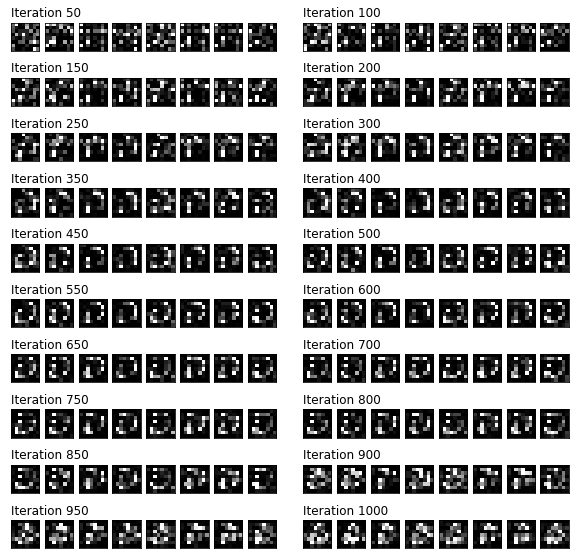

In [45]:
fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(10, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()